In [4]:
import numpy as np
import matplotlib.pyplot as plt

import pypolar.jones as jones
import pypolar.visualization as vis

np.set_printoptions(suppress=True)  # print 1e-16 as zero

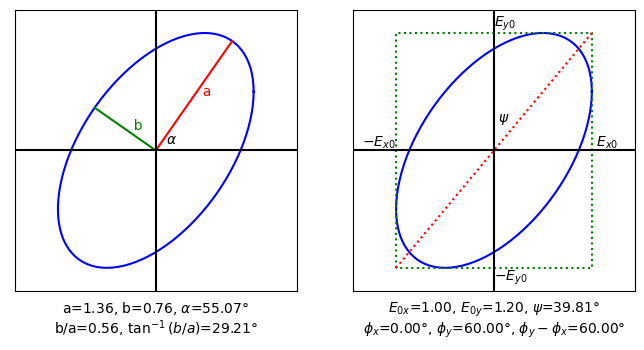

In [2]:
phi=np.pi/3
v = np.array([1,1.2*np.exp(phi*1j)])
vis.draw_jones_ellipse(v)
plt.show()

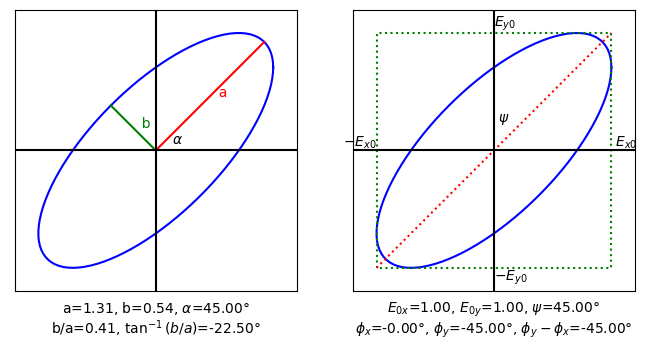

Jones vector
     [1.        +0.j         0.70710678+0.70710678j]

            pypolar   Hecht
alpha          45.0°    45.0°  horizontal to major-axis
a             1.307    1.310  semi-major axis
b             0.541    0.542  semi-minor axis
b/a            0.41     0.41  
ellipticity    22.5°    22.5°  arctan(b/a)

E_x0            1.0      1.0
E_y0            1.0      1.0
psi            45.0°    45.0°  arctan(Ey0/Ex0)
phi_y-phi_x    45.0°    45.0° 


In [3]:
jones.use_alternate_convention(True)

v=np.array([1.0,
            1.0*np.exp(1j*np.pi/4.0)])

vis.draw_jones_ellipse(v)
plt.show()

ani = vis.draw_jones_animated(v,nframes=32)

# The rest of the parameters in Hecht

Delta=jones.phase(v)
psi=jones.amplitude_ratio_angle(v)
alpha=jones.ellipse_azimuth(v)
beta=jones.ellipticity_angle(v)
a,b = jones.ellipse_axes(v)
E_x,E_y = np.abs(v)

jones.use_alternate_convention(False)

print('Jones vector')
print('    ',v)
print()
print('            pypolar   Hecht')

print('alpha        %6.1f°  %6.1f°  horizontal to major-axis' % (np.degrees(alpha),45))
print('a            %6.3f   %6.3f  semi-major axis' % (a,1.31))
print('b            %6.3f   %6.3f  semi-minor axis' % (b,0.542))
print('b/a          %6.2f   %6.2f  ' % (b/a,0.41))
print('ellipticity  %6.1f°  %6.1f°  arctan(b/a)' % (np.degrees(beta),22.5))

print()
print('E_x0         %6.1f   %6.1f' % (E_x,1))
print('E_y0         %6.1f   %6.1f' % (E_y,1))
print('psi          %6.1f°  %6.1f°  arctan(Ey0/Ex0)' % (np.degrees(psi),45))
print('phi_y-phi_x  %6.1f°  %6.1f° ' % (np.degrees(Delta), 45))

ani

In [31]:
class JonesMatrix():
    '''Create a Jones matrix represented various optical materials'''
    def __init__(self, Delta_n=0, optic_axis=[1, 0, 0], ray_dir=[1, 0, 0], thickness=1):
        self.Delta_n = Delta_n
        self.optic_axis = np.array(optic_axis) / np.linalg.norm(optic_axis)
        self.ray_dir = np.array(ray_dir)
        self.ray_dir_basis = self.calc_rayDir(self.ray_dir)
        self.thickness = thickness

        self.wavelength = 0.550

    def LR_test(self):
        '''Linear retarder'''
        R = self.Delta_n
        M = np.array([[np.ones_like(R), np.zeros_like(R)],
                    [np.zeros_like(R), np.exp(-1j * R)]], dtype=complex)
        return M
    
    def calc_retardance(self):
        ret = abs(self.Delta_n) * (1 - np.dot(self.optic_axis, self.ray_dir) ** 2) * 2 * np.pi * self.thickness / self.wavelength
        # print(f"Accumulated retardance from index ellipsoid is {np.around(np.rad2deg(ret), decimals=0)} ~ {int(np.rad2deg(ret)) % 360} degrees.")
        return ret

    def calc_azimuth(self):
        azim = np.arctan2(np.dot(self.optic_axis, self.ray_dir_basis[1]), np.dot(self.optic_axis, self.ray_dir_basis[2]))
        # print(f"Azimuth angle of index ellipsoid is {np.around(np.rad2deg(azim), decimals=0)} degrees.")
        return azim

    def rotator(self, angle):
        '''2D rotation matrix
        Args:
            angle: angle to rotate by counterclockwise [radians]
        Return: Jones matrix'''
        s = np.sin(angle)
        c = np.cos(angle)
        R = np.array([[c, -s], [s, c]])
        return R

    def LR(self, ret, azim):
        '''Linear retarder
        Args:
            ret (float): retardance [radians]
            azim (float): azimuth angle of fast axis [radians]
        Return: Jones matrix    
        '''
        J00 = np.cos(ret / 2) + 1j * np.cos(2 * azim) * np.sin(ret / 2)
        J11 = np.conj(J00)
        J01 = 1j * np.sin(2 * azim) * np.sin(ret / 2)
        J10 = J01
        return np.array([[J00, J10], [J01, J11]])

    def LR_from_product(self, ret, azim):
        '''Linear retarder
        Args:
            ret (float): retardance [radians]
            azim (float): azimuth angle of fast axis [radians]
        Return: Jones matrix    
        '''
        retardor_azim0 = self.LR_azim0(ret)
        R = self.rotator(azim)
        Rinv = self.rotator(-azim)
        return R @ retardor_azim0 @ Rinv

    def LR_azim0(self, ret):
        return np.array([[np.exp(1j * ret / 2), 0], [0, np.exp(-1j * ret / 2)]])

    def LR_azim90(self, ret):
        return np.array([[np.exp(-1j * ret / 2), 0], [0, np.exp(1j * ret / 2)]])

    def QWP(self, azim):
        '''Quarter Waveplate
        Linear retarder with lambda/4 or equiv pi/2 radians
        Commonly used to convert linear polarized light to circularly polarized light'''
        ret = np.pi / 2
        return self.LR_from_product(ret, azim)

    def HWP(self, azim):
        '''Half Waveplate
        Linear retarder with lambda/2 or equiv pi radians
        Commonly used to rotate the plane of linear polarization'''
        # Faster method
        s = np.sin(2 * azim)
        c = np.cos(2 * azim)
        JM = np.array([[c, s], [s, -c]])
        # # Alternative method
        # ret = np.pi
        # JM = self.LR_from_product(ret, azim)
        return JM

    def rotation_matrix(self, axis, angle):
        '''Generates the rotation matrix that will rotate a 3D vector
        around "axis" by "angle" counterclockwise.'''
        ax, ay, az = axis[0], axis[1], axis[2]
        s = np.sin(angle)
        c = np.cos(angle)
        u = 1 - c
        R_tuple = ( ( ax*ax*u + c,    ax*ay*u - az*s, ax*az*u + ay*s ),
            ( ay*ax*u + az*s, ay*ay*u + c,    ay*az*u - ax*s ),
            ( az*ax*u - ay*s, az*ay*u + ax*s, az*az*u + c    ) )
        R = np.asarray(R_tuple)
        return R

    def find_orthogonal_vec(self, v1, v2):
        '''v1 and v2 are numpy arrays (3d vectors)
        This function accomodates for a divide by zero error.'''
        value = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        # Check if vectors are parallel or anti-parallel
        if np.linalg.norm(value) == 1:
            if v1[1] == 0:
                normal_vec = np.array([0, 1, 0])
            elif v1[2] == 0:
                normal_vec = np.array([0, 0, 1])
            elif v1[0] == 0:
                normal_vec = np.array([1, 0, 0])
            else:
                non_par_vec = np.array([1, 0, 0])
                normal_vec = np.cross(v1, non_par_vec) / np.linalg.norm(np.cross(v1, non_par_vec))
        else:
            normal_vec = np.cross(v1, v2) / np.linalg.norm(np.cross(v1, v2))
        return normal_vec
    
    def calc_rayDir(self, ray):
        '''
        Allows to the calculations to be done in ray-space coordinates
        as oppossed to laboratory coordinates
        Parameters:
            ray (np.array): normalized 3D vector giving the direction 
                            of the light ray
        Returns:
            ray (np.array): same as input
            ray_perp1 (np.array): normalized 3D vector
            ray_perp2 (np.array): normalized 3D vector
        '''
        # ray = ray / np.linalg.norm(ray)    # in case ray is not a unit vector <- does not need to be normalized
        theta = np.arccos(np.dot(ray, np.array([1,0,0])))
        # Unit vectors that give the laboratory axes, can be changed
        scope_axis = np.array([1,0,0])
        scope_perp1 = np.array([0,1,0])
        scope_perp2 = np.array([0,0,1])
        theta = np.arccos(np.dot(ray, scope_axis))
        # print(f"Rotating by {np.around(np.rad2deg(theta), decimals=0)} degrees")
        normal_vec = self.find_orthogonal_vec(ray, scope_axis)
        Rinv = self.rotation_matrix(normal_vec, -theta)
        # Extracting basis vectors that are orthogonal to the ray and will be parallel
        # to the laboratory axes that are not the optic axis after a rotation.
        # Note: If scope_perp1 if the y-axis, then ray_perp1 if the 2nd column of Rinv.
        ray_perp1 = np.dot(Rinv, scope_perp1)
        ray_perp2 = np.dot(Rinv, scope_perp2)
        return [ray, ray_perp1, ray_perp2]
    
    ###########################################################################################
    # Three identical ways of calculating the Jones matrix of a linear birefringent voxel
    def LR_material(self):
        Delta_n = self.Delta_n
        opticAxis = self.optic_axis
        rayDir = self.ray_dir_basis
        ell = self.thickness
        wavelength = self.wavelength
        azim = np.arctan2(np.dot(opticAxis, rayDir[1]), np.dot(opticAxis, rayDir[2]))
        if Delta_n == 0:
            azim = 0
        elif Delta_n < 0:
            azim = azim + np.pi / 2
        ret = abs(Delta_n) * (1 - np.dot(opticAxis, rayDir[0]) ** 2) * 2 * np.pi * ell / wavelength
        offdiag = 1j * np.sin(2 * azim) * np.sin(ret / 2)
        diag1 = np.cos(ret / 2) + 1j * np.cos(2 * azim) * np.sin(ret / 2)
        diag2 = np.conj(diag1)
        # Check JM computation: Set ell=wavelength (from Kliger appendix)
        # JM00 = np.exp(1j*ret/2) * np.cos(azim)**2 + np.exp(-1j*ret/2) * np.sin(azim)**2
        # JM10 = 2j * np.sin(azim) * np.cos(azim) * np.sin(ret/2)
        # JM11 = np.exp(-1j*ret/2) * np.cos(azim)**2 + np.exp(1j*ret/2) * np.sin(azim)**2
        return np.matrix([[diag1, offdiag], [offdiag, diag2]])

    def LR_mat(self):
        ret = self.calc_retardance()
        azim = self.calc_azimuth()
        if self.Delta_n == 0:
            azim = 0
        elif self.Delta_n < 0:
            azim = azim + np.pi / 2
        return self.LR(ret, azim)

    def LR_mat_from_product(self):
        '''Advancing fast/slow axis and slowing down slow/fast axis (not sure which)'''
        ret = self.calc_retardance()
        azim = self.calc_azimuth()
        if self.Delta_n == 0:
            azim = 0
        elif self.Delta_n < 0:
            azim = azim + np.pi / 2
        retardor_azim0 = np.array([[np.exp(1j * ret / 2), 0], [0, np.exp(-1j * ret / 2)]])
        R = self.rotator(azim)
        Rinv = self.rotator(-azim)
        return R @ retardor_azim0 @ Rinv
    
    def LR_mat_from_product_neg(self):
        '''90 deg azimuth rotation of function above
        - not consistent with other methods'''
        ret = self.calc_retardance()
        azim = self.calc_azimuth()
        if self.Delta_n == 0:
            azim = 0
        elif self.Delta_n < 0:
            azim = azim + np.pi / 2
        retardor_azim0 = np.array([[np.exp(-1j * ret / 2), 0], [0, np.exp(1j * ret / 2)]])
        R = self.rotator(azim)
        Rinv = self.rotator(-azim)
        return R @ retardor_azim0 @ Rinv
    ###########################################################################################

    def LP(self, theta):
        '''Linear Polarizer
        Args:
            theta: angle that light can pass through
        Returns: Jones matrix
        '''
        c = np.cos(theta)
        s = np.sin(theta)
        J00 = c ** 2
        J11 = s ** 2
        J01 = s * c
        J10 = J01
        return np.array([[J00, J01], [J10, J11]])

    def LP_from_product(self, theta):
        '''Linear Polarizer
        Args:
            theta: angle that light can pass through
        Returns: Jones matrix
        '''
        c = np.cos(theta)
        s = np.sin(theta)
        J00 = c ** 2
        J11 = s ** 2
        J01 = s * c
        J10 = J01
        LP0 = np.array([[1, 0], [0, 0]])
        return self.rotator(theta) @ LP0 @ self.rotator(-theta)

    # static method
    def RCP(self):
        '''Right Circular Polarizer'''
        return 1 / 2 * np.array([[1, -1j], [1j, 1]])

    # static method
    def LCP(self):
        '''Left Circular Polarizer'''
        return 1 / 2 * np.array([[1, 1j], [-1j, 1]])

    def RCR(self, ret):
        '''Right Circular Retarder'''
        return self.rotator(- ret / 2)

    def LCR(self, ret):
        '''Left Circular Retarder'''
        return self.rotator(ret / 2)


In [30]:
1/2 * np.array([2, 3])

array([1. , 1.5])

In [28]:
JM = JonesMatrix(Delta_n=1, optic_axis=[0, 1, 1], ray_dir=[1, 0, 0], thickness=2)
JM.LR(np.pi, 0)
print(JM.LR_material())
print(JM.LR_mat())
print(JM.LR_mat_from_product())
print(JM.LR_mat_from_product_neg())
JM.quarter_waveplate(0)

[[ 0.41541501-0.j       -0.        -0.909632j]
 [-0.        -0.909632j  0.41541501+0.j      ]]
[[ 0.41541501-0.j       -0.        -0.909632j]
 [-0.        -0.909632j  0.41541501+0.j      ]]
[[ 0.41541501-0.j       -0.        -0.909632j]
 [-0.        -0.909632j  0.41541501-0.j      ]]
[[ 0.41541501+0.j       -0.        +0.909632j]
 [-0.        +0.909632j  0.41541501+0.j      ]]


array([[0.70710678+0.70710678j, 0.        +0.j        ],
       [0.        +0.j        , 0.70710678-0.70710678j]])

In [177]:
JM.LR_mat()

matrix([[ 0.41541501-0.j      , -0.        -0.909632j],
        [-0.        -0.909632j,  0.41541501+0.j      ]])

In [178]:
JM.calc_retardance()

22.84794657156213

In [184]:
JM.LR_material()

matrix([[ 0.41541501-0.j      , -0.        -0.909632j],
        [-0.        -0.909632j,  0.41541501+0.j      ]])

In [166]:
JM.quarter_waveplate()

matrix([[0.70710678+0.70710678j, 0.        +0.j        ],
        [0.        +0.j        , 0.70710678-0.70710678j]])

In [6]:
JM = JonesMatrix(Delta_n=1, optic_axis=[0, 1, 1], ray_dir=[1, 0, 0], thickness=2)

In [29]:
import time
st = time.time()
for i in range(10000):
    JM.LR_material()
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

st = time.time()
for i in range(10000):
    JM.LR_mat()
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

st = time.time()
for i in range(10000):
    JM.LR_mat_from_product()
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


Execution time: 0.4406595230102539 seconds
Execution time: 0.28353238105773926 seconds
Execution time: 0.42874646186828613 seconds


In [130]:
class JonesMatrixCharacteristics():
    '''Input is a Jones matrix. Method give properties about it.'''
    def __init__(self, JM):
        self.JM = JM

    def list_elements(self):
        J00 = round(self.JM[0, 0], 3)
        J10 = round(self.JM[1, 0], 3)
        J01 = round(self.JM[0, 1], 3)
        J11 = round(self.JM[1, 0], 3)
        print("Jones matrix elements are the following:")
        print(f"\t J00: {J00} \t J01: {J01}")
        print(f"\t J10: {J10} \t J11: {J11}")

    def rad2deg(self, rad):
        deg = np.round(np.rad2deg(rad), 1)
        return deg

    def eig(self):
        values, vectors = np.linalg.eig(self.JM)
        return values, vectors

    def retardance(self):
        '''Phase delay introduced between the fast and slow axis'''
        values, vectors = self.eig()
        e1 = values[0]
        e2 = values[1]
        phase_diff = np.angle(e1) - np.angle(e2)
        return np.abs(phase_diff)

    def azimuth(self):
        '''Rotation angle of the fast axis (neg phase)'''
        values, vectors = self.eig()
        real_vecs = np.real(vectors)
        if np.imag(values[0]) < 0:
            fast_vector = real_vecs[0]
            if fast_vector[0] == fast_vector[1] and real_vecs[1][1] < 0:
                azim = 3 * np.pi / 4
            else:
                azim = np.arccos(fast_vector[1])
        else:
            fast_vector = real_vecs[1]
            azim = np.arccos(fast_vector[1])   # good except for when Delta_n is neg and imag(value[0]) is pos
        if azim < 0:
            azim = azim + np.pi
        return azim
    
    def azimuth_og(self):
        '''Computes azimuth directly from Jones matrix components'''
        JM = self.JM
        diag_sum = JM[0, 0] + JM[1, 1]
        diag_diff = JM[1, 1] - JM[0, 0]
        off_diag_sum = JM[0, 1] + JM[1, 0]
        a = np.imag(diag_diff / diag_sum)
        b = np.imag(off_diag_sum / diag_sum)
        if a == 0 and b == 0:
            azimuth = 0
        else:
            azimuth = np.real(np.arctan2(a, b)) / 2 + np.pi / 2
        print(f"azimuth from jones components {self.rad2deg(azimuth)} degrees")
        return azimuth

    def retarder_type(self):
        '''Check if retarder
        - intensity of light and deg of polarization remain unchanged (eigenvalue norms are 1)
        - based on eigenvectors, determine if linear, circular, or the general elliptical
        - linear if two orthogonal eigenpolarization'''
        pass


In [110]:
JonesMatrixCharacteristics(np.array([[1/3, 0], [0, 1]])).list_elements()
my_JM = JonesMatrixCharacteristics(np.array([[1/3j, 1j], [1+2j, 1]]))
my_JM.retardance()
my_JM.azimuth()
my_JM.azimuth_og()

Jones matrix elements are the following:
	 J00: 0.333 	 J01: 0.0
	 J10: 0.0 	 J11: 0.0
azimuth from eigenvector0 [-37.5  29.5] degrees
azimuth from eigenvector1 [-48.4  52.5] degrees
azimuth from jones components 95.7 degrees


1.669494106719837

In [111]:
my_JM.azimuth()
print(my_JM.phase())
np.angle(my_JM.JM)
my_JM.azimuth_og()


azimuth from eigenvector0 [-37.5  29.5] degrees
azimuth from eigenvector1 [-48.4  52.5] degrees
[ 3.14159265 -1.10714872]
azimuth from jones components 95.7 degrees


1.669494106719837

In [112]:
JM_LC = JonesMatrix()

TypeError: JonesMatrix.__init__() missing 1 required positional argument: 'JM'

In [ ]:
def test_azimuth():
        azim_list_pos = []
        eig_list_pos = []
        eigvec_list_pos = []
        for i in range(6):
            optic_axis = [1, i, 1]
            JM = JonesMatrix(Delta_n=0.1, optic_axis=optic_axis)
            my_JM = JM.LR_material()
            JM_prop = JonesMatrixProperties(my_JM)
            meas = JM_prop.azimuth()
            azim = np.array([JM.calc_azimuth(), JM_prop.azimuth_og(), meas, JM_prop.azimuth_tangent()])
            azim = np.round(np.rad2deg(azim), 1)
            azim_list_pos.append(azim)
            vals = JM_prop.eig()[0]
            vals_comp = [np.real(vals[0]), np.imag(vals[0]), np.real(vals[1]), np.imag(vals[1])]
            eig_list_pos.append(np.round(vals_comp, 2))
            eigvec_list_pos.append(np.round(JM_prop.eig()[1], 2))
        for i in range(6):
            optic_axis = [1, 1, i]
            JM = JonesMatrix(Delta_n=0.1, optic_axis=optic_axis)
            my_JM = JM.LR_material()
            JM_prop = JonesMatrixProperties(my_JM)
            meas = JM_prop.azimuth()
            azim = np.array([JM.calc_azimuth(), JM_prop.azimuth_og(), meas, JM_prop.azimuth_tangent()])
            azim = np.round(np.rad2deg(azim), 1)
            azim_list_pos.append(azim)
            vals = JM_prop.eig()[0]
            vals_comp = [np.real(vals[0]), np.imag(vals[0]), np.real(vals[1]), np.imag(vals[1])]
            eig_list_pos.append(np.round(vals_comp, 2))
            eigvec_list_pos.append(np.round(JM_prop.eig()[1], 2))

        azim_list_neg = []
        eig_list_neg = []
        eigvec_list_neg = []
        for i in range(6):
            optic_axis = [1, i, 1]
            JM = JonesMatrix(Delta_n=-0.1, optic_axis=optic_axis)
            my_JM = JM.LR_material()
            JM_prop = JonesMatrixProperties(my_JM)
            meas = JM_prop.azimuth()
            azim = np.array([JM.calc_azimuth(), JM_prop.azimuth_og(), meas, JM_prop.azimuth_tangent()])
            azim = np.round(np.rad2deg(azim), 1)
            azim_list_neg.append(azim)
            vals = JM_prop.eig()[0]
            vals_comp = [np.real(vals[0]), np.imag(vals[0]), np.real(vals[1]), np.imag(vals[1])]
            eig_list_neg.append(np.round(vals_comp, 2))
            eigvec_list_neg.append(np.round(JM_prop.eig()[1], 2))
        for i in range(6):
            optic_axis = [1, 1, i]
            JM = JonesMatrix(Delta_n=-0.1, optic_axis=optic_axis)
            my_JM = JM.LR_material()
            JM_prop = JonesMatrixProperties(my_JM)
            meas = JM_prop.azimuth()
            azim = np.array([JM.calc_azimuth(), JM_prop.azimuth_og(), meas, JM_prop.azimuth_tangent()])
            azim = np.round(np.rad2deg(azim), 1)
            azim_list_neg.append(azim)
            vals = JM_prop.eig()[0]
            vals_comp = [np.real(vals[0]), np.imag(vals[0]), np.real(vals[1]), np.imag(vals[1])]
            eig_list_neg.append(np.round(vals_comp, 2))
            eigvec_list_neg.append(np.round(JM_prop.eig()[1], 2))

In [64]:
def PrintParam(
        param,
        verbose=True,
        draw=True,
        statistics=True,
        shape=None,
        # shape_like=None,
        # shape_obj=None,
        title='',
        heading=''):
    """Function to print the information during the calculation of some parameters.

    Parameters:
        param (np.array, list or tuple): List of variables to be represented.
        verbose (bool): If True, print the numeric values. Default: True.
        draw (bool): If True, plot 1D and 2D parameters. Default: True.
        statistics (bool): If True, a basic statistical analysis will be performed. Default: True.
        shape (list or tuple): Shape of the elements.
        title (string or list): Title or list of titles (1-D and 2-D elements).
    """
    # Print heading
    print(heading)
    # Calculate the length of the number of parameters
    try:
        if isinstance(param, list) or isinstance(param, tuple):
            l = len(param)
            if l == 1:
                param = param[0]
                if isinstance(title, list) or isinstance(title, tuple):
                    title = title[0]
        else:
            l = 1
    except:
        l = 1
    # Calculate the dimension
    # if shape is not None:
    #     ndim = len(shape)
    # else:
    #     try:
    #         if l == 1:
    #             if param.size == 1:
    #                 ndim = 0
    #             else:
    #                 ndim = param.ndim
    #         else:
    #             if param[0].size == 1:
    #                 ndim = 0
    #             else:
    #                 ndim = param[0].ndim
    #     except:
    #         ndim = 0
    # print(ndim)
    try:
        if l == 1:
            if param.size == 1:
                ndim = 0
            else:
                ndim = param.ndim
        else:
            if param[0].size == 1:
                ndim = 0
            else:
                ndim = param[0].ndim
    except:
        if shape is not None:
            ndim = len(shape)
        else:
            ndim = 0
    # Check if there are complex or bool parameters
    if l == 1:
        is_complex = np.iscomplex(param).any()
        if isinstance(param, np.ndarray):
            is_bool = param.dtype is np.dtype(bool)
        else:
            is_bool = False
    else:
        is_complex = False
        is_bool = []
        for p in param:
            is_complex = is_complex or np.iscomplex(p).any()
            if isinstance(p, np.ndarray):
                is_bool.append(p.dtype is np.dtype(bool))
            else:
                is_bool.append(False)

    # Calculate desired size for figs
    if ndim == 1 or ndim == 2:
        figsize = [5, 5]
        if is_complex:
            figsize[1] = l * figsize_default[1]
            figsize[0] = 2 * figsize_default[0]
        else:
            f, c = NumberOfSubplots(l)
            figsize[1] = f * figsize_default[1]
            figsize[0] = c * figsize_default[0]

    # If verbose, print
    if verbose:
        # 0-D: just one element. Use letters only.
        if l == 1:
            print(param)
        else:
            for ind, p in enumerate(param):
                print('  ' + title[ind])
                print(p)

    # Draws
    if draw and ndim == 0:
        print('Low dimensionality, figure not available.')
    elif draw and ndim == 1:
        # 1-D: row element. Use plot.
        fig = plt.figure(figsize=figsize)
        if l == 1:
            if is_complex:
                plt.subplot(1, 2, 1)
                plt.plot(np.real(param))
                plt.title(title + ' (real)')
                # plt.colorbar()
                plt.subplot(1, 2, 2)
                plt.plot(np.imag(param))
                plt.title(title + ' (imaginary)')
                # plt.colorbar()
            else:
                plt.plot(param)
                plt.title(title)
        else:
            # Check if there are complex parameters
            for ind, p in enumerate(param):
                if is_complex:
                    plt.subplot(l, 2, 2 * ind + 1)
                    plt.plot(np.real(p))
                    plt.title(title[ind] + ' (real)')
                    plt.subplot(l, 2, 2 * ind + 2)
                    plt.plot(np.imag(p))
                    plt.title(title[ind] + ' (imaginary)')
                else:
                    plt.subplot(f, c, ind + 1)
                    if is_bool[ind]:
                        plt.plot(p.astype(int))
                    else:
                        plt.plot(p)
                    plt.title(title[ind])
        fig.canvas.draw_idle()
    elif draw and ndim == 2:
        # 2-D: Use imshow
        fig = plt.figure(figsize=figsize)
        if l == 1:
            if is_complex:
                plt.subplot(1, 2, 1)
                plt.imshow(np.real(param))
                plt.title(title + ' (real)')
                plt.colorbar()
                plt.subplot(1, 2, 2)
                plt.imshow(np.imag(param))
                plt.title(title + ' (imaginary)')
                plt.colorbar()
            else:
                if is_bool:
                    param = param.astype(float)
                plt.imshow(param)
                plt.title(title)
                plt.colorbar()
        else:
            for ind, p in enumerate(param):
                if is_complex:
                    plt.subplot(l, 2, 2 * ind + 1)
                    plt.imshow(np.real(p))
                    plt.title(title[ind] + ' (real)')
                    plt.colorbar()
                    plt.subplot(l, 2, 2 * ind + 2)
                    plt.imshow(np.imag(p))
                    plt.title(title[ind] + ' (imaginary)')
                    plt.colorbar()
                else:
                    plt.subplot(f, c, ind + 1)
                    if is_bool[ind]:
                        p = p.astype(float)
                    plt.imshow(p)
                    plt.title(title[ind])
                    plt.colorbar()
        fig.canvas.draw_idle()
    elif draw:
        print('High dimensionality, figure not available.')

    # Statistics
    if statistics and ndim > 0:
        if l == 1:
            mean = np.mean(param)
            std = np.std(param)
            print('The mean value is {} +- {}'.format(mean, std))
        else:
            for ind, p in enumerate(param):
                mean = np.mean(p)
                std = np.std(p)
                print('The mean value of param {} is {} +- {}'.format(
                    title[ind], mean, std))
    # End
    plt.show()
    print('')
    return None